In [2]:
import torch
import numpy as np
import pandas as pd
import glob
import os
import pickle

from tqdm import tqdm
from pathlib import Path
from sklearn.pipeline import Pipeline
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

from pymo.preprocessing import *

import warnings
warnings.filterwarnings("ignore")

In [93]:
class EmotionsMovementsDataset(torch.utils.data.Dataset):
    def __init__(self, records_path, transform_pipeline=None, fit_transform=False, signal_len=120):
        records_path = Path(records_path)
        self.root_path = records_path.parent
        self.signals_list = pd.read_csv(records_path)   
        self.transform_pipeline = transform_pipeline
        self.signal_len=signal_len
        
        if self.transform_pipeline is not None and fit_transform:
            self.__fit_transform_pipeline()
        
    def __fit_transform_pipeline(self):
        data = [self.__getrawitem(i)[0] for i in range(len(self))]
        self.transform_pipeline.fit(data)
    
    def __getrawitem(self, idx):
        signal_metadata = self.signals_list.iloc[idx]
        signal_id, signal_label = signal_metadata['id'], signal_metadata['label']
        with open(Path(self.root_path, signal_id + '.pkl'), 'rb') as fd:
            bvh_position = pickle.load(fd)
        return bvh_position, signal_metadata['label']
        
    def __len__(self):
        return self.signals_list.shape[0]
    
    def __getitem__(self, idx):
        X, signal_label = self.__getrawitem(idx)

        if self.transform_pipeline is not None:
            X = self.transform_pipeline.transform([X])[0].astype(np.float32)
            
        X = X[-self.signal_len:, :] # get last signal_len timestemps
        # pad if needed in the beginning
        if X.shape[0] < self.signal_len:
            X = np.pad(X, ((self.signal_len - X.shape[0], 0), (0, 0)), mode='edge')        
        
        return torch.from_numpy(X), signal_label

In [186]:
transform_pipeline = Pipeline([
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
#     ('selector', JointSelector(['Spine', 'RightFoot', 'LeftFoot', 'Head', 'RightForeArm', 'LeftForeArm'], include_root=True)),
    ('np', Numpyfier()),
    ('down', DownSampler(10)),
    ('stdscale', ListStandardScaler())
])

train_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/train.csv',
    transform_pipeline=transform_pipeline,
    fit_transform=True,
    signal_len=120
)
print('Transform fitted!')
val_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/val.csv',
    transform_pipeline=train_ds.transform_pipeline,
    fit_transform=False,
    signal_len=120
)
test_ds = EmotionsMovementsDataset(
    '/datasets/extra_space2/ostap/kinematic-dataset-of-actors-expressing-emotions-2.1.0/PyMO_output/test.csv',
    transform_pipeline=train_ds.transform_pipeline,
    fit_transform=False,
    signal_len=120
)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=10)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=10, shuffle=False, num_workers=10)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=10, shuffle=False, num_workers=10)
X_sample = train_ds[0]

Transform fitted!


### Get adjacency matrix

In [187]:
mocap_data, _ = train_ds._EmotionsMovementsDataset__getrawitem(0)
mocap_data = [mocap_data]
for _, transform_step in train_ds.transform_pipeline.steps[:-3]:
    mocap_data = transform_step.transform(mocap_data)
mocap_data

In [188]:
def get_adjacency_matrix(mocap_data, num_channels=3):
    nodes_num = mocap_data.values.shape[1] // num_channels    
    # assign nodes numbers
    used_nodes = {}
    for i, name in enumerate(mocap_data.values.columns):
        node_name = '_'.join(name.split('_')[:-1])
        if node_name not in used_nodes:
            used_nodes[node_name] = i // num_channels
        else:
            assert used_nodes[node_name] == i // num_channels
    
    # construct adj. matrix
    A = np.zeros((nodes_num, nodes_num))
    for node_name, props in mocap_data.skeleton.items():
        parent = props['parent']
        if parent is None:
            continue
        node_idx, parent_idx = used_nodes[node_name], used_nodes[parent]
        A[node_idx, parent_idx] = 1
        A[parent_idx, node_idx] = 1
        
    return A

A = get_adjacency_matrix(mocap_data[0], num_channels=3)

In [218]:
A_fourway = ((A + A@A + A@A@A + A@A@A@A) > 0).astype(np.int64) - np.eye(A.shape[0])

### Define model

### GCNN

In [219]:
class GraphConvLayer(nn.Module):
    def __init__(self, A, in_channels, out_channels, add_identity=True, aggregation='sum'):
        super().__init__()
        A = torch.FloatTensor(A)
        if add_identity:
            A = A + torch.eye(A.size(0))
            
        if aggregation == 'sum':
            pass
        elif aggregation == 'mean':
            d = 1 / torch.sum(A, dim=1)
            A = A * d.unsqueeze(-1)
        elif aggregation == 'spectral':
            d = 1 / torch.sqrt(torch.sum(A, dim=1))
            A = A * d * d.unsqueeze(-1)
        else:
            raise ValueError(f'Wrong aggregation method provided! ({aggregation})')
            
        self.register_buffer('aggregation_matrix', A) 
        self.linear = nn.Linear(in_channels, out_channels)
        
    def forward(self, x):
        *batch_size, nodes_num, feature_size = x.size()
        x = torch.matmul(self.aggregation_matrix, x)
        x = x.view(-1, feature_size)
        x = self.linear(x)
        x = x.view(*batch_size, nodes_num, -1)
        return x

In [220]:
a = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

gcl = GraphConvLayer(a, in_channels=4, out_channels=10, aggregation='spectral')

In [221]:
x = torch.randn(150, 10, 3, 4)
gcl(x).shape

torch.Size([150, 10, 3, 10])

In [224]:
class EmotionConvBasic(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()
        self.output_size = output_size
        self.conv_layers = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv1d(in_channels, 256, kernel_size=3, padding=1, dilation=5)),
            ('relu1', nn.ReLU(inplace=True)),
            ('bn1', nn.BatchNorm1d(256)),
            
            ('conv2', nn.Conv1d(256, 256, kernel_size=3, padding=1, dilation=5)),
            ('relu2', nn.ReLU(inplace=True)),
            ('bn2', nn.BatchNorm1d(256)),
            ('pool2', nn.MaxPool1d(kernel_size=2, stride=2)),
            
            ('conv3', nn.Conv1d(256, 512, kernel_size=3, padding=1, dilation=3)),
            ('relu3', nn.ReLU(inplace=True)),
            ('bn3', nn.BatchNorm1d(512)),
            
            ('conv6', nn.Conv1d(512, 512, kernel_size=3, padding=1, dilation=3)),
            ('relu6', nn.ReLU(inplace=True)),
            ('bn6', nn.BatchNorm1d(512)),
            ('pool6', nn.MaxPool1d(kernel_size=2, stride=2)),
        ]))
        
        self.fc = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(512, 256)),
            ('relu1', nn.ReLU(inplace=True)),
#             ('fc2', nn.Linear(256, 256)),
#             ('relu2', nn.ReLU(inplace=True)),
            ('fc3', nn.Linear(256, self.output_size)),
        ]))
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv_layers(x)
        x = x.mean(dim=2) # global average pooling
        return self.fc(x)

class GemotionNet(nn.Module):
    def __init__(self, A, in_channels, nodes_num, output_size):
        super().__init__()
        self.in_channels = in_channels
        self.nodes_num = nodes_num
        self.output_size = output_size
        self.gcnn = nn.Sequential(OrderedDict([
            ('gconv1', GraphConvLayer(A, in_channels, 16, add_identity=True, aggregation='spectral')),
            ('relu1', nn.ReLU(inplace=True)),
            ('gconv2', GraphConvLayer(A, 16, 32, add_identity=True, aggregation='spectral')),
            ('relu2', nn.ReLU(inplace=True)),
#             ('gconv3', GraphConvLayer(A, 32, 64, add_identity=True, aggregation='spectral')),
#             ('relu3', nn.ReLU(inplace=True)),
#             ('gconv4', GraphConvLayer(A, 64, 128, add_identity=True, aggregation='spectral')),
#             ('relu4', nn.ReLU(inplace=True)),
        ]))
        
        self.conv_classifier = EmotionConvBasic(in_channels=32*nodes_num, output_size=output_size)
    
    def forward(self, x):
        batch_size, seq_len, c = x.size()
        x = x.view(batch_size, seq_len, -1, self.in_channels)
        x = self.gcnn(x)
        x = x.view(batch_size, seq_len, -1)
        x = self.conv_classifier(x)
        return x

In [225]:
model = GemotionNet(A=A_fourway, in_channels=3, nodes_num=72, output_size=7)
X = next(iter(train_dl))[0]
print(X.shape)
print(model(X).shape)

torch.Size([10, 120, 216])
torch.Size([10, 7])


In [226]:
summary(model, input_size=(240, 216), batch_size=10, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [10, 16]              64
    GraphConvLayer-2          [10, 240, 72, 16]               0
              ReLU-3          [10, 240, 72, 16]               0
            Linear-4                   [10, 32]             544
    GraphConvLayer-5          [10, 240, 72, 32]               0
              ReLU-6          [10, 240, 72, 32]               0
            Conv1d-7             [10, 256, 232]       1,769,728
              ReLU-8             [10, 256, 232]               0
       BatchNorm1d-9             [10, 256, 232]             512
           Conv1d-10             [10, 256, 224]         196,864
             ReLU-11             [10, 256, 224]               0
      BatchNorm1d-12             [10, 256, 224]             512
        MaxPool1d-13             [10, 256, 112]               0
           Conv1d-14             [10, 5

### Train loop

In [227]:
device = torch.device('cuda:2')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

In [228]:
@torch.no_grad()
def test(model, test_dl, criterion, device):
    model.eval()
    batch_loss = []
    samples, correct = 0, 0
    for X_batch, y_batch in tqdm(test_dl):
        batch_size = X_batch.shape[0]
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = model(X_batch)
        test_loss = criterion(y_pred, y_batch)
        batch_loss.append(test_loss.item())

        # evaluate accuracy
        batch_correct = (torch.argmax(y_pred, dim=1) == y_batch).sum().item()
        samples += batch_size
        correct += batch_correct

    
    return np.mean(batch_loss), correct / samples

In [229]:
def train(model, train_dl, val_dl, epochs, criterion, optimizer, scheduler, path_to_model):

    train_loss, val_loss = [], []
    highest_val_accuracy = 0
    
    for epoch in range(epochs):
        model.train()

        batch_train_loss = []

        for X_batch, y_batch in tqdm(train_dl):
            # perform single training step
            model.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            batch_train_loss.append(loss.item())
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        
        epoch_train_loss = np.mean(batch_train_loss)
        train_loss.append(epoch_train_loss)
        epoch_val_loss, val_accuracy = test(model, val_dl, criterion, device)
        val_loss.append(epoch_val_loss)

        if val_accuracy > highest_val_accuracy:
            highest_val_accuracy = val_accuracy
            torch.save(model.state_dict(), path_to_model)
            
        scheduler.step()

        print(f"Epoch {epoch + 1}, train loss: {epoch_train_loss}, val_loss: {epoch_val_loss},  val accu: {val_accuracy}")

    model.load_state_dict(torch.load(path_to_model))

    return train_loss, val_loss

In [230]:
train(
    model,
    train_dl, 
    val_dl,
    epochs=50,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    path_to_model='model_gcnn.pth'
)

  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1, train loss: 2.0961657113262584, val_loss: 1.8353211561838785,  val accu: 0.2978723404255319


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 2, train loss: 1.8605482376047544, val_loss: 1.8068360487620037,  val accu: 0.20567375886524822


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3, train loss: 1.8035896505628313, val_loss: 1.8676209767659506,  val accu: 0.3120567375886525


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4, train loss: 1.6734639507319247, val_loss: 1.8201829671859742,  val accu: 0.3049645390070922


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5, train loss: 1.6237971750753266, val_loss: 1.7844235976537068,  val accu: 0.41134751773049644


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6, train loss: 1.5543711898582322, val_loss: 1.792241390546163,  val accu: 0.3404255319148936


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7, train loss: 1.4858579635620117, val_loss: 1.5691613992055258,  val accu: 0.45390070921985815


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8, train loss: 1.4692989949669157, val_loss: 1.786903691291809,  val accu: 0.4397163120567376


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9, train loss: 1.4549432529934816, val_loss: 3.502985644340515,  val accu: 0.375886524822695


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 10, train loss: 1.3748791201838426, val_loss: 1.687197756767273,  val accu: 0.48936170212765956


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11, train loss: 1.231896805443934, val_loss: 1.6025867462158203,  val accu: 0.48936170212765956


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12, train loss: 1.1065124746944224, val_loss: 1.478904871145884,  val accu: 0.5177304964539007


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13, train loss: 1.069288773196084, val_loss: 1.5143625736236572,  val accu: 0.5106382978723404


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14, train loss: 1.0831147908632244, val_loss: 1.438617726167043,  val accu: 0.5177304964539007


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15, train loss: 0.9931314329483679, val_loss: 1.4879401723543804,  val accu: 0.5390070921985816


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16, train loss: 0.9607512088758605, val_loss: 1.5306195457776388,  val accu: 0.49645390070921985


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 17, train loss: 0.9133878986218146, val_loss: 1.9233631094296773,  val accu: 0.5319148936170213


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 18, train loss: 0.9045513737946749, val_loss: 1.3708146850268046,  val accu: 0.5886524822695035


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 19, train loss: 0.8692178907138961, val_loss: 1.6394891083240508,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 20, train loss: 0.812615932364549, val_loss: 1.5259201486905416,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21, train loss: 0.6707865675645215, val_loss: 1.2280643542607625,  val accu: 0.6099290780141844


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22, train loss: 0.6110116932541132, val_loss: 1.4290363868077596,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23, train loss: 0.595685469917953, val_loss: 1.3442461768786111,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24, train loss: 0.5484365807580096, val_loss: 1.5027197519938151,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25, train loss: 0.5032103631778487, val_loss: 1.5199601769447326,  val accu: 0.6382978723404256


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26, train loss: 0.4854700953167464, val_loss: 1.4679800768693287,  val accu: 0.6028368794326241


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 27, train loss: 0.4818705047613808, val_loss: 1.796922250588735,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 28, train loss: 0.4498462660703808, val_loss: 1.3927305420239766,  val accu: 0.6099290780141844


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 29, train loss: 0.4183904842939228, val_loss: 1.4264478345712026,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 30, train loss: 0.41729003257517305, val_loss: 1.4206987738609314,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 31, train loss: 0.36143442832066547, val_loss: 1.2974597692489624,  val accu: 0.6028368794326241


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 32, train loss: 0.351607298212392, val_loss: 1.328938865661621,  val accu: 0.6028368794326241


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 33, train loss: 0.3203560492090349, val_loss: 1.6612290958563487,  val accu: 0.574468085106383


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 34, train loss: 0.3407188397832215, val_loss: 1.4343315839767456,  val accu: 0.6028368794326241


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 35, train loss: 0.32762463527199415, val_loss: 2.685870385169983,  val accu: 0.5602836879432624


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 36, train loss: 0.2955613041662478, val_loss: 1.4230066061019897,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 37, train loss: 0.2926866502966732, val_loss: 1.4717220703760783,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 38, train loss: 0.3197147900105587, val_loss: 1.3799875617027282,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 39, train loss: 0.2939815191285951, val_loss: 1.4750437517960866,  val accu: 0.574468085106383


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 40, train loss: 0.26527397271378766, val_loss: 1.494576229651769,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 41, train loss: 0.25688387994055767, val_loss: 1.6777040640513101,  val accu: 0.5815602836879432


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 42, train loss: 0.23750947304402611, val_loss: 1.5066017627716064,  val accu: 0.5886524822695035


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 43, train loss: 0.25762721204331945, val_loss: 1.6281474828720093,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 44, train loss: 0.2659640948487712, val_loss: 1.5083961288134258,  val accu: 0.6028368794326241


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 45, train loss: 0.25047698710113764, val_loss: 1.9132433633009593,  val accu: 0.5886524822695035


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 46, train loss: 0.24003713341828967, val_loss: 1.5016451597213745,  val accu: 0.5957446808510638


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 47, train loss: 0.24839452546023363, val_loss: 1.463441757361094,  val accu: 0.574468085106383


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 48, train loss: 0.24901841118532633, val_loss: 1.466358075539271,  val accu: 0.5886524822695035


  0%|          | 0/112 [00:00<?, ?it/s]

Epoch 49, train loss: 0.2456886068768134, val_loss: 1.4460155924161275,  val accu: 0.6099290780141844


100%|██████████| 15/15 [00:03<00:00,  4.24it/s]

Epoch 50, train loss: 0.2567216764270727, val_loss: 2.297782242298126,  val accu: 0.5815602836879432


([2.0961657113262584,
  1.8605482376047544,
  1.8035896505628313,
  1.6734639507319247,
  1.6237971750753266,
  1.5543711898582322,
  1.4858579635620117,
  1.4692989949669157,
  1.4549432529934816,
  1.3748791201838426,
  1.231896805443934,
  1.1065124746944224,
  1.069288773196084,
  1.0831147908632244,
  0.9931314329483679,
  0.9607512088758605,
  0.9133878986218146,
  0.9045513737946749,
  0.8692178907138961,
  0.812615932364549,
  0.6707865675645215,
  0.6110116932541132,
  0.595685469917953,
  0.5484365807580096,
  0.5032103631778487,
  0.4854700953167464,
  0.4818705047613808,
  0.4498462660703808,
  0.4183904842939228,
  0.41729003257517305,
  0.36143442832066547,
  0.351607298212392,
  0.3203560492090349,
  0.3407188397832215,
  0.32762463527199415,
  0.2955613041662478,
  0.2926866502966732,
  0.3197147900105587,
  0.2939815191285951,
  0.26527397271378766,
  0.25688387994055767,
  0.23750947304402611,
  0.25762721204331945,
  0.2659640948487712,
  0.25047698710113764,
  0.240

In [232]:
state_dict = torch.load('model_gcnn.pth')
model.load_state_dict(state_dict)
test(model, test_dl, criterion, device)

100%|██████████| 15/15 [00:03<00:00,  4.23it/s]


(2.5051753640174867, 0.5531914893617021)

In [44]:
y_true_all, y_pred_all = [], []
for X, y_true in tqdm(test_dl):
    y_pred = model(X.to(device))
    y_pred = y_pred.argmax(dim=1)
    y_true_all.extend(y_true.tolist())
    y_pred_all.extend(y_pred.tolist())    

100%|██████████| 15/15 [00:03<00:00,  4.99it/s]


In [45]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap, barplot, histplot
import matplotlib.pyplot as plt

In [46]:
labels_to_idx = {'A': 0, 'D': 1, 'F': 2, 'H': 3, 'N': 4, 'SA': 5, 'SU': 6}
idx_to_label = {v:k for k,v in labels_to_idx.items()}
idx_to_label.values()

dict_values(['A', 'D', 'F', 'H', 'N', 'SA', 'SU'])

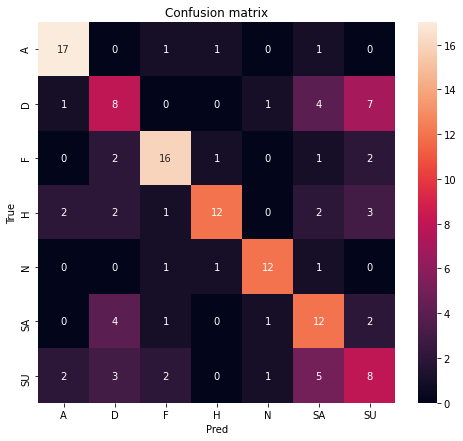

In [47]:
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 7))
heatmap(cm, annot=True, xticklabels=idx_to_label.values(), yticklabels=idx_to_label.values())
plt.xlabel('Pred')
plt.ylabel('True')
plt.title('Confusion matrix');

<AxesSubplot:ylabel='Count'>

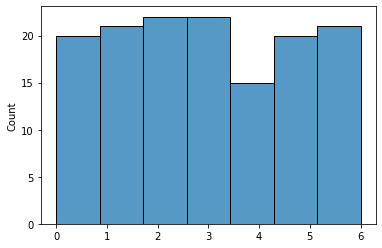

In [25]:
histplot(y_true_all, bins=7)

### Parse graph of human body